Богомолов Владислав

Лабораторная работа 3

Загружаем инструменты

In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


Загрузим модель

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Загрузим 4 изображения и выведем их

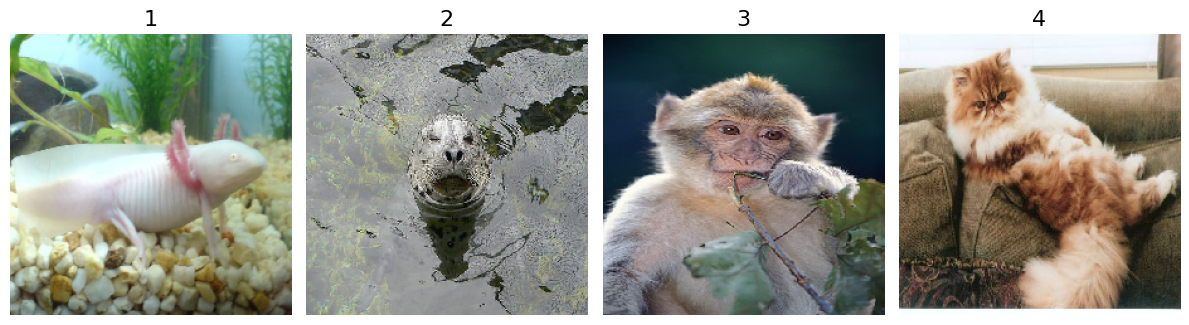

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

image_titles = ['1', '2', '3', '4']

img0 = load_img('1.jpeg', target_size=(224, 224))
img1 = load_img('2.jpeg', target_size=(224, 224))
img2 = load_img('3.jpeg', target_size=(224, 224))
img3 = load_img('4.jpeg', target_size=(224, 224))
images = np.asarray([np.array(img0), np.array(img1), np.array(img2), np.array(img3)])

X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Заменим функцию активации на линейную

In [6]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

Создадим функцию очков соответсвия каждому изображению

In [7]:
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([11, 12, 13, 14])
def score_function(output):
    return (output[0][11], output[1][12], output[2][13], output[3][14])

Создадим карту внимания (vanilla)

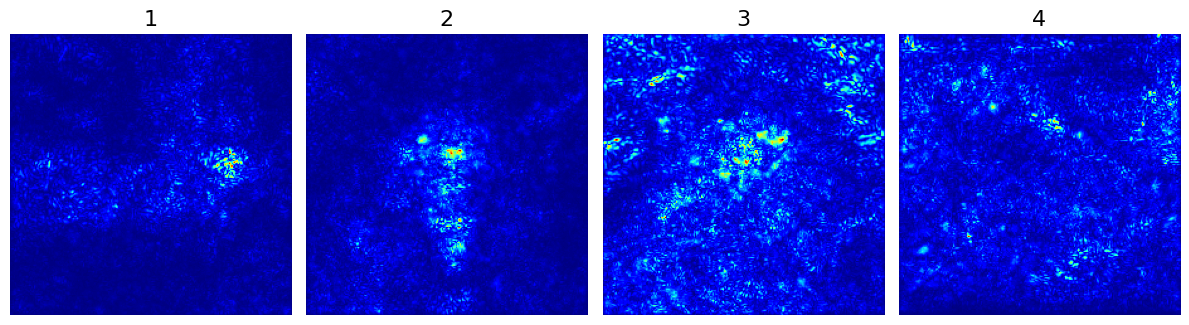

In [8]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model,model_modifier=replace2linear,clone=True)

saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Уменьшим шум для карт влияния

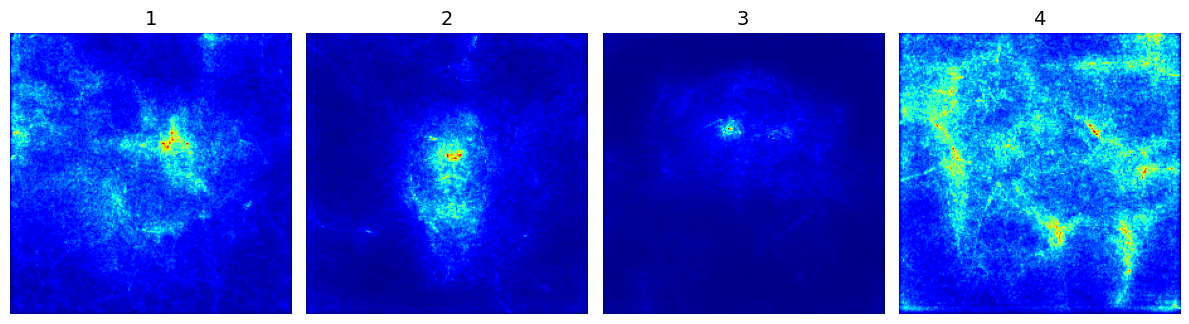

CPU times: user 2.08 s, sys: 243 ms, total: 2.33 s
Wall time: 3.62 s


In [9]:
%%time
saliency_map = saliency(score,X,smooth_samples=20,smooth_noise=0.20)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

Используем GrandCAM

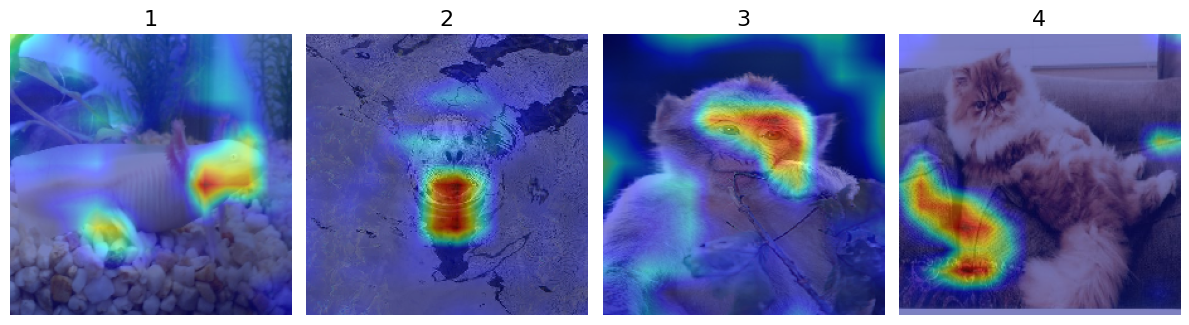

CPU times: user 1.53 s, sys: 763 ms, total: 2.29 s
Wall time: 2.18 s


In [10]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,model_modifier=replace2linear,clone=True)

cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

 Используем GradCAM++

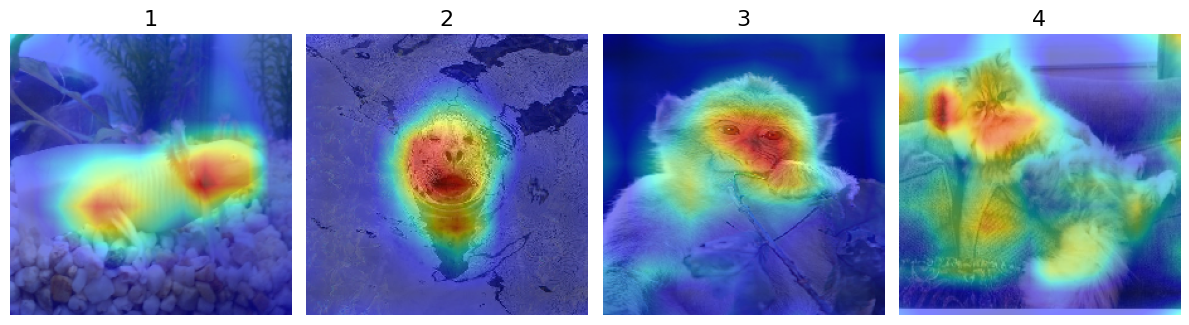

CPU times: user 2.54 s, sys: 844 ms, total: 3.39 s
Wall time: 3.54 s


In [11]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(model,model_modifier=replace2linear,clone=True)

cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()